In [ ]:
import os
import sys
import glob
# from argparse import ArgumentParser
import nibabel as nib
# import scipy.io as sio
# from scipy.interpolate import interpn
# sys.path.append('../ext/medipy-lib')
# import medipy
# from medipy.metrics import dice
# import datagenerators

# project
#import networks
# sys.path.append('../ext/neuron')
#import neuron.layers as nrn_layers
import matplotlib.pyplot as plt
!pip install antspyx
import ants
# import nibabel as nib
import numpy as np
# import matplotlib.pyplot as plt
# import natsort

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# we assume that all the data is in same orientation 

#  input Data Path
## write your own routine to get fiels path from directory

In [ ]:
# neuro_dir_path= '/..../..../..../.....'
# # !ls $neuro_dir_path1 
# image_paths_train = glob.glob(neuro_dir_path+"*T1.img")
# label_paths_train = glob.glob(neuro_dir_path+"*label.img")



In [ ]:
/content/gdrive/MyDrive/iseg_2017/iSeg-2017-Training/subject-1-T1.hdr

# select for fixed/ source data

In [ ]:
atlse_seg_file='/content/gdrive/MyDrive/iseg_2017/iSeg-2017-Training/subject-6-label.img'
atlas_img_file='/content/gdrive/MyDrive/iseg_2017/iSeg-2017-Training/subject-6-T1.img'
fixed_norm_atlas = ants.image_read( atlas_img_file )
fixed_seg_atlas    = ants.image_read( atlse_seg_file )
ref = nib.load(atlas_img_file)

# look for labels

In [ ]:
print(np.unique(fixed_seg_atlas.numpy()))

[  0.  10. 150. 250.]


# choose data folder where data should be saved after affine

In [ ]:

affined_data_folder='/content/gdrive/MyDrive/iseg_2017/affined_syn'
os.mkdir(affined_data_folder)


FileExistsError: ignored

In [ ]:
moving_seg_file='/content/gdrive/MyDrive/iseg_2017/iSeg-2017-Training/subject-1-label.img'
moving_img_file='/content/gdrive/MyDrive/iseg_2017/iSeg-2017-Training//subject-1-T1.img'


In [ ]:
moving_norm= ants.image_read(moving_img_file )
moving_seg   = ants.image_read( moving_seg_file )
ref = nib.load(moving_img_file)

# checking oreintation of both fixed(source) and moving(target) image

In [ ]:
print("fixed_norm_atlas.direction")
print(fixed_norm_atlas.direction)
print("moving_norm.direction")
print(moving_norm.direction)

fixed_norm_atlas.direction
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
moving_norm.direction
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
print("fixed_seg_atlas.direction")
print(fixed_seg_atlas.direction)
print("moving_seg.direction")
print(moving_seg.direction)

fixed_seg_atlas.direction
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
moving_seg.direction
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [ ]:
print(moving_norm.orientation)

RAI


In [ ]:
print(moving_seg.orientation)

RAI


In [ ]:
print(moving_seg.get_orientation)

functools.partial(<bound method get_orientation of ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (144, 192, 256)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
>)


In [ ]:
print(fixed_norm_atlas.shape)

(144, 192, 256)


Text(0.5, 1.0, 'segmentation before affine alignemnt')

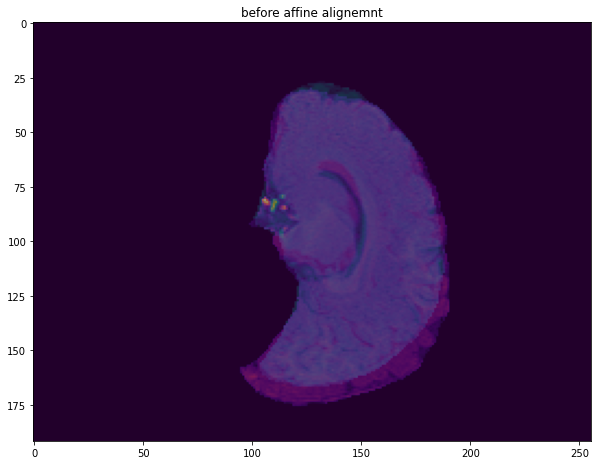

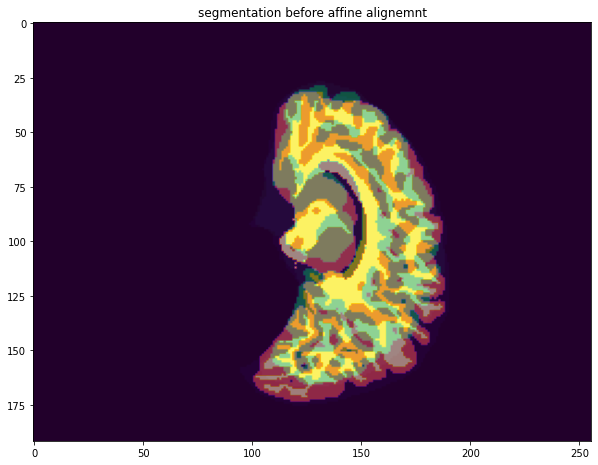

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(fixed_norm_atlas[80,...])
plt.imshow(moving_norm[80,...],cmap='inferno',alpha=0.5)
plt.title("before affine alignemnt")
plt.figure(figsize=(10, 10))
plt.imshow(fixed_seg_atlas[80,...])
plt.imshow(moving_seg[80,...],cmap='inferno',alpha=0.5)
plt.title("segmentation before affine alignemnt")

In [ ]:
#brinigng everything in same oreintation
ants.set_direction(fixed_seg_atlas,fixed_norm_atlas.direction) 
ants.set_direction(moving_seg,fixed_norm_atlas.direction) 

# affine registration

In [ ]:
mytx = ants.registration(fixed=fixed_norm_atlas , moving=moving_norm, type_of_transform='Affine' , reg_iterations= (1000,1000,1000,1000))
print(mytx.keys())
# getting warped moving image
warped_moving_norm = mytx['warpedmovout']
#applying transformation matrix to moving segmentation
warped_moving_seg = ants.apply_transforms(fixed=fixed_norm_atlas, moving=moving_seg,
                                  transformlist=mytx['fwdtransforms'],interpolator='nearestNeighbor')

dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])


In [ ]:
fixed_norm_atlas.direction

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
fixed_seg_atlas.direction

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Text(0.5, 1.0, 'segmentation after affine alignemnt')

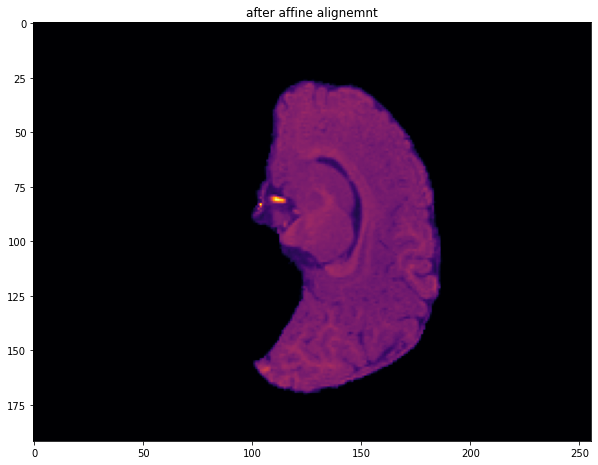

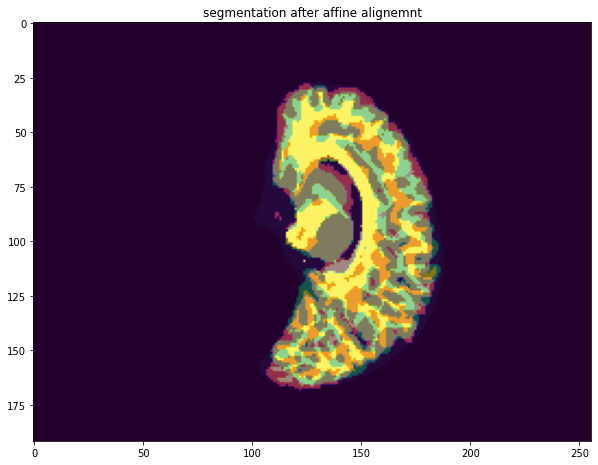

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(fixed_norm_atlas[80,...])
plt.imshow(warped_moving_norm[80,...],cmap='inferno')#,alpha=0.5
plt.title("after affine alignemnt")
plt.figure(figsize=(10, 10))
plt.imshow(fixed_seg_atlas[80,...])
plt.imshow(warped_moving_seg[80,...],cmap='inferno',alpha=0.5)
plt.title("segmentation after affine alignemnt")

# computing dice score before and after

In [ ]:
def dice(vol1, vol2, labels=None, nargout=1):
    '''
    Dice Code is from voxelmorph
    Dice [1] volume overlap metric

    The default is to *not* return a measure for the background layer (label = 0)

    [1] Dice, Lee R. "Measures of the amount of ecologic association between species."
    Ecology 26.3 (1945): 297-302.

    Parameters
    ----------
    vol1 : nd array. The first volume (e.g. predicted volume)
    vol2 : nd array. The second volume (e.g. "true" volume)
    labels : optional vector of labels on which to compute Dice.
        If this is not provided, Dice is computed on all non-background (non-0) labels
    nargout : optional control of output arguments. if 1, output Dice measure(s).
        if 2, output tuple of (Dice, labels)

    Output
    ------
    if nargout == 1 : dice : vector of dice measures for each labels
    if nargout == 2 : (dice, labels) : where labels is a vector of the labels on which
        dice was computed
    '''
    if labels is None:
        labels = np.unique(np.concatenate((vol1, vol2)))
        labels = np.delete(labels, np.where(labels == 0))  # remove background

    dicem = np.zeros(len(labels))
    for idx, lab in enumerate(labels):
        vol1l = vol1 == lab
        vol2l = vol2 == lab
        top = 2 * np.sum(np.logical_and(vol1l, vol2l))
        bottom = np.sum(vol1l) + np.sum(vol2l)
        bottom = np.maximum(bottom, np.finfo(float).eps)  # add epsilon.
        dicem[idx] = top / bottom

    if nargout == 1:
        return dicem
    else:
        return (dicem, labels)


In [ ]:
# moving_seg.shape

# fixed_seg_atlas.shape

labels=[10., 150., 250.]


In [ ]:
np.unique(fixed_seg_atlas.numpy())

array([  0.,  10., 150., 250.], dtype=float32)

In [ ]:
#dice beofre
dice1=dice(fixed_seg_atlas.numpy(),moving_seg.numpy(),labels=labels)
print(dice1)

[0.32246604 0.52610023 0.53402362]


In [ ]:
#dice after affine

dice1=dice(fixed_seg_atlas.numpy(),warped_moving_seg.numpy(),labels=labels)
print(dice1)

[0.53900455 0.62287805 0.60536603]


# saving affined image and segment

In [ ]:
ants.image_write(warped_moving_norm,'moved_img.img')
ants.image_write(warped_moving_seg,'moved_seg.img')


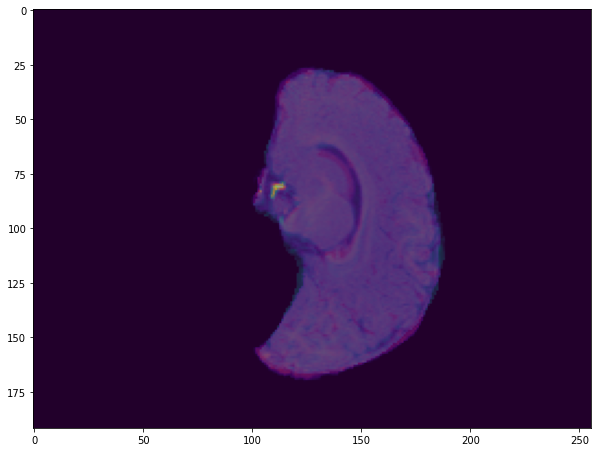

In [ ]:
#checking saved image

imgg=ants.image_read('moved_img.img')
plt.figure(figsize=(10, 10))
plt.imshow(fixed_norm_atlas[80,...])
plt.imshow(imgg[80,...],cmap='inferno',alpha=0.5)

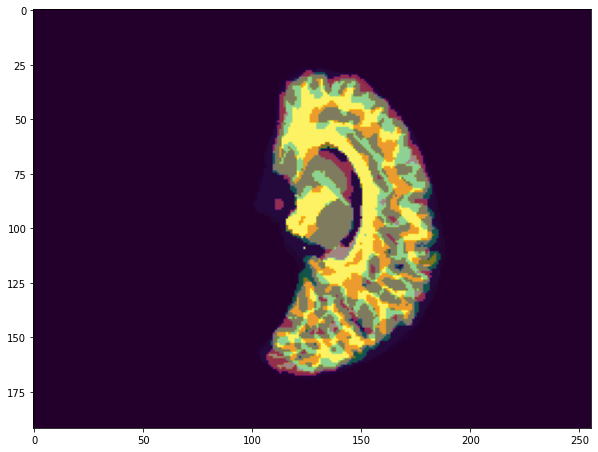

In [ ]:
#checking saved image


imgg=ants.image_read('moved_seg.img')
plt.figure(figsize=(10, 10))
plt.imshow(fixed_seg_atlas[80,...])
plt.imshow(imgg[80,...],cmap='inferno',alpha=0.5)

In [ ]:
imgg.direction

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

# Nor-rigid registraion

• “ElasticSyN”: Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric and elastic regularization.
• “SyN”: Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric.
• “SyNRA”: Symmetric normalization: Rigid + Affine + deformable transformation, with mutual
information as optimization metric.
• “SyNOnly”: Symmetric normalization: no initial transformation, with mutual information as
optimization metric. Assumes images are aligned by an inital transformation. Can be useful
if you want to run an unmasked affine followed by masked deformable registration.

In [ ]:
mytx_non_rigid = ants.registration(fixed=fixed_norm_atlas , moving=warped_moving_norm, type_of_transform='SyN', grad_step=0.25 , reg_iterations=(50,50,50, ),flow_sigma=9,total_sigma=0.2)
   
print(mytx_non_rigid.keys())
# getting warped moving image
warped_moving_norm_non_rigid = mytx_non_rigid['warpedmovout']
#applying transformation matrix to moving segmentation
warped_moving_seg_non_rigid = ants.apply_transforms(fixed=fixed_norm_atlas, moving=warped_moving_seg,
                                  transformlist=mytx_non_rigid['fwdtransforms'],interpolator='nearestNeighbor')

dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])


In [ ]:
#dice after non-rigid

dice1=dice(fixed_seg_atlas.numpy(),warped_moving_seg_non_rigid.numpy(),labels=labels)
print(dice1)

[0.70424443 0.6816581  0.65827495]


Text(0.5, 1.0, 'segmentation after non-rigid alignemnt')

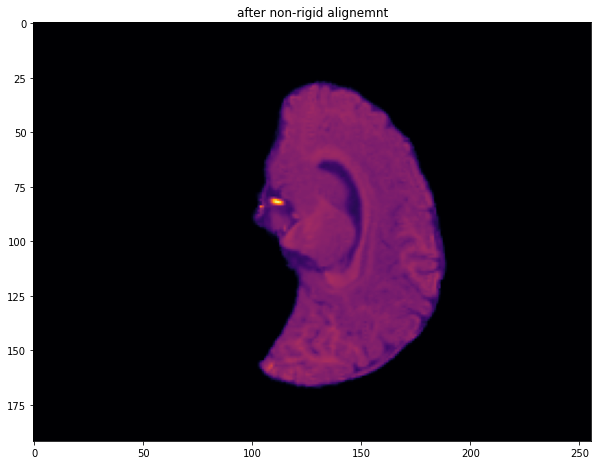

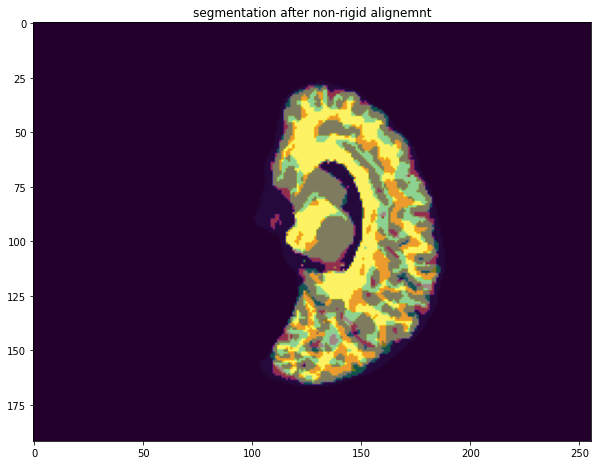

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(fixed_norm_atlas[80,...])
plt.imshow(warped_moving_norm_non_rigid[80,...],cmap='inferno')#,alpha=0.5
plt.title("after non-rigid alignemnt")
plt.figure(figsize=(10, 10))
plt.imshow(fixed_seg_atlas[80,...])
plt.imshow(warped_moving_seg_non_rigid[80,...],cmap='inferno',alpha=0.5)
plt.title("segmentation after non-rigid alignemnt")